In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange

## Task 1.1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
import gym

total_reward = 0
N_EPISODES = 100000
env = gym.make('Blackjack-v1', natural=False, sab=False)

for _ in range(N_EPISODES):
    observation, info = env.reset()
    
    episode_reward = 0
    terminated = False
    while terminated == False:
        if observation[0] < 19:
            action = 1
        else:
            action = 0
        observation, reward, terminated, _, _ = env.step(action)
        episode_reward += reward
    total_reward += episode_reward
env.close()

print(total_reward / N_EPISODES)

-0.20541


## Task 1.2

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [4]:
def get_random_V(env):
    space = env.observation_space
    s_shape = space[0].n, space[1].n, space[2].n
    V = np.random.random(s_shape)
    return V.reshape(-1)

def get_random_Q(env):
    space = env.observation_space
    q_shape = space[0].n, space[1].n, space[2].n, env.action_space.n
    Q = np.random.random(q_shape)
    return Q.reshape(-1, env.action_space.n)

def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax(Q, axis=1)

def observation_to_num(observation, env):
    space = env.observation_space
    s_shape = space[0].n, space[1].n, space[2].n
    return observation[0] * space[1].n * space[2].n + observation[1] * space[2].n + int(observation[2])

def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    observation, info = env.reset()
    s_idx = observation_to_num(observation, env)
    s, a = s_idx, pi[s_idx] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
    for _ in range(1000):
        observation, reward, done, info, _ = env.step(a)
        s_idx = observation_to_num(observation, env)
        s_prime, a_prime = s_idx, pi[s_idx] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
            
def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        observation, info = env.reset()
        s_idx = observation_to_num(observation, env)
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            observation, reward, done, info, _ = env.step(pi[s_idx])
            s_idx = observation_to_num(observation, env)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    env.close()
    return np.mean(total_reward), np.mean(num_steps)

In [5]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
total_episodes = 15000
gamma = 0.9

# Q_max = compute_Q_max(env, gamma)
# pi_max = compute_policy_by_Q(env, Q_max)

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.1, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

In [21]:
num_experiments, num_experiments_pi = 1, 100000
total_episodes = 100000
gamma = 0.9

eval_steps = 1000

results_Qlearn = []

Q_arr = [ get_random_Q(env) for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]

for n in trange(1, total_episodes+1):
    _ = [ Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments) ]
    pi_arr = [ compute_policy_by_Q(env, Q) for Q in Q_arr ]
    if n % eval_steps == 0:
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

## Task 1.3

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Text(0.5, 0, 'Эпизоды')

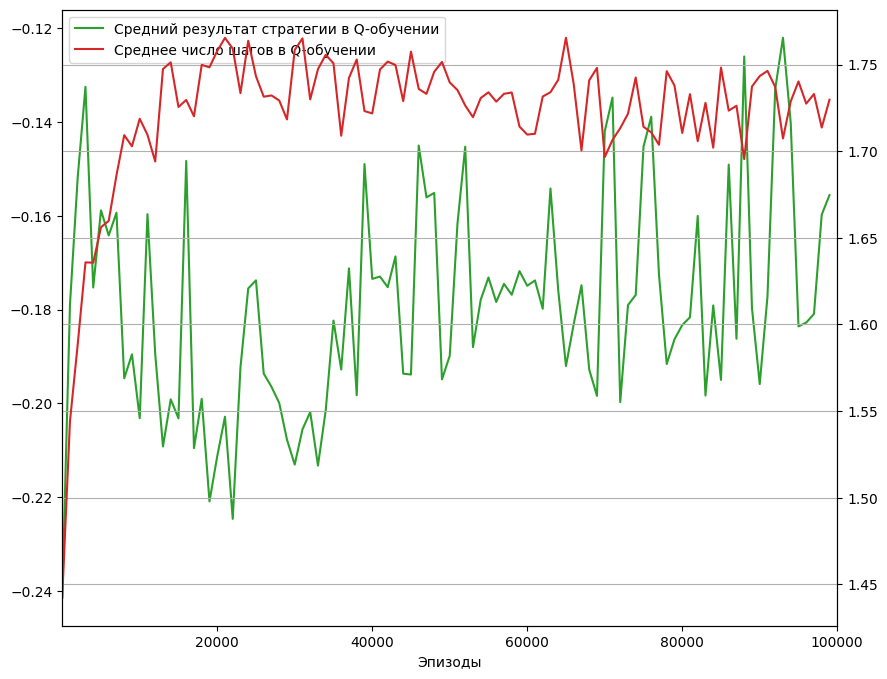

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax2 = ax.twinx()
ax2.grid(None)

avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

line3 = ax.plot(np.arange(1, total_episodes+1, eval_steps), avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
line4 = ax2.plot(np.arange(1, total_episodes+1, eval_steps), avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")

lines = line3 + line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper left")
# ax.set_xlim((0.5, 1.0))
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")